## Running SV's adaptation of MV's event delineation/hysteresis index calc R script

### See email from SV on 05/24/2024

In [1]:
setwd("/home/millieginty/Documents/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/")

In [ ]:
# Calculate the hysteresis and flushing indices based on Vaughan et al. 2017 (WRR)
# We are going to use the smoothed P time series for hysteresis (simple moving average over 9 rows; 9 * 15 min = 135 min or 2.25 hrs)


# Load packages
library(tidyverse)
library(lubridate)
library(data.table)
library(zoo)
library(dplyr)
library(ggplot2)

# Compile event delineations, chemistry, & discharge data into a single data frame
hb_events <- read.csv("hb_events_hyst.csv")
hb_chem_q <- read.csv("hb_q_chem copy.csv")

hb_events$event_start <- as.POSIXct(hb_events$event_start, format="%m/%d/%y %H:%M")
hb_events$event_end <- as.POSIXct(hb_events$event_end, format="%m/%d/%y %H:%M")
hb_chem_q$datetime <- as.POSIXct(hb_chem_q$datetime, format="%Y-%m-%dT%H:%M:%SZ")
hb_chem_q$timestamp <- copy(hb_chem_q$datetime)

setDT(hb_events)
setDT(hb_chem_q)


# Perform a non-equi join to match rows within the date range
#This data frame just has q/chem data that corresponds with an event
merged_data <- hb_chem_q[hb_events, on = .(datetime >= event_start, datetime <= event_end), nomatch = 0, allow.cartesian = TRUE]

merged_data <- merged_data %>%
  rename(event_end = datetime.1) %>%
  rename(event_start = datetime)

all_data <- merged_data %>%
  # Simplify analyte names from mg/L to just chem. abbrev.
  #rename(TP = TP_mgL) %>% 
  # Simplify q_cms to just q
  rename(q = q_cms_hb_filled) %>%
  # # Filter rows without chemistry
  filter(!is.na(NO3)) %>% 
  filter(!is.na(TDP)) %>% 
  filter(!is.na(TP)) %>% 
  filter(!is.na(SRP)) %>% 
  filter(!is.na(PP)) %>% 
  # Add a condition column, i.e., event vs. baseflow
  mutate(condition = ifelse(is.na(event_ID), "baseflow", "event")) %>% 
  # Add a year column
  mutate(year = year(timestamp))
# Rearrange columns
#select(timestamp, year, condition, event_start, event_end, q, NO3, TP)


# Prepare the data ----
# Look at event data only
eventdata <- all_data %>% 
  filter(condition == "event") %>% 
  # Keep only necessary columns
  #select(site, timestamp, event_start, event_end, q, NO3, TP, SRP) %>% 
  # Try removing rows with no Q
  filter(!is.na(q))

hyst_indices <- full_join(FI, HI, by = c("event_start", "event_end"))

# Define the function to determine the season based on the event_start date
#get_season <- function(date) {
  #month <- month(date)
  #if (month %in% c(12, 1, 2)) {
    #return("Winter")
  # else if (month %in% c(3, 4, 5)) {
    #return("Spring")
  #} else if (month %in% c(6, 7, 8)) {
    #return("Summer")
  #} else if (month %in% c(9, 10, 11)) {
    #return("Fall")
  #}
#}

# Create Q sequence onto which we'll interpolate later
q_step <- hb_events %>% select(event_start, event_end)
# Check to see how many unique site + storms there are
# howmany <- q_step %>% group_by(site, event_start) %>% summarize(count = n())
# q_step <- setDT(q_step)[, list(q = seq(from = 0, to = 1, by = 0.01)), by = c("site", "event_start", "event_end")]
# Using mutate(q = q/100) below because creating a vector using by = 0.01 resulted in floating point precision problems later in the script
# https://stackoverflow.com/questions/55956654/when-i-use-dplyrfilter-and-a-sequence-command-it-randomly-skips-rows-it-should/55958991#55958991
q_step <- setDT(q_step)[, list(q = seq(from = 0, to = 100)), by = c("event_start", "event_end")] %>% 
  mutate(q = q/100)


# Slice the data on the rising limb of each storm
# If a solute concentration doesn't change during a storm, e.g., when NO3 is at MDL, the normalization will produce NaN (can't devide by 0)
hyst_rise <- eventdata %>% 
  # Normalize (between 0 and 1) Q and solutes
  group_by(event_start) %>% 
  # mutate(q_norm = (q - min(q)) / (max(q) - min(q))) %>% 
  mutate_at(vars(c(q, NO3, TP, SRP, TDP, PP)),
            .funs = list(~ (. - min(.)) / (max(.) - min(.)))) %>%
  # funs((. - min(.)) / (max(.) - min(.)))) %>%
  # Arrange data by site and timestamp for the slice below
  arrange(timestamp) %>% 
  # Slice data from start of storm to max q
  slice(1:which.max(q)) %>% 
  select(-timestamp) %>% 
  ungroup()

# Slice the data on the falling limb of each storm 
hyst_fall <- eventdata %>% 
  group_by(event_start) %>% 
  mutate_at(vars(c(q, NO3, TP, SRP, TDP, PP)),
            .funs = list(~ (. - min(.)) / (max(.) - min(.)))) %>%
  # funs((. - min(.)) / (max(.) - min(.)))) %>%
  arrange(timestamp) %>% 
  # Select rows from max Q to end of the storm
  slice(which.max(q):length(q)) %>% 
  # Slice again, this time from max Q to the first minimum Q for the storm
  slice(1:which.min(q)) %>%
  select(-timestamp) %>% 
  ungroup()


# 1. Join the q_step to hyst_rise & hyst_fall
# 2. Interpolate missing normalized solute values
# Convert q_step, hyst_rise & hyst_fall to DT's and set the keys to join on
setDT(q_step)
setkey(q_step, event_start, event_end, q)
setDT(hyst_rise)
setkey(hyst_rise, event_start, event_end, q)
setDT(hyst_fall)
setkey(hyst_fall, event_start, event_end, q)

### saved version 
hyst_rise <- 
  # Join with q_step & sort data
  merge(hyst_rise, q_step, all = TRUE)[order(event_start, q)] %>% 
  # Rename columns
  rename(NO3_rise = NO3, TP_rise = TP, SRP_rise = SRP, TDP_rise = TDP, PP_rise = PP) %>% 
  # Interpolate missing normalized solute values
  group_by(event_start) %>%                         ###    <------  CODE IS BREAKING HERE "Error in .f(.x[[i]], ...) : object 'NO3' not found"
  mutate_at(vars(c(NO3_rise, TP_rise, SRP_rise, TDP_rise, PP_rise)),
            # funs(na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
            .funs = list(~ na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
  # Only keep rows where q matches the q_step above
  filter(q %in% (seq(1,100)/100)) %>% 
  # Take the average of any duplicate values of Q for each site and storm
  gather(key = "var", value = "val", c(NO3_rise, TP_rise, SRP_rise, TDP_rise, PP_rise)) %>% 
  group_by(event_start, event_end, q, var) %>% 
  summarize(val = mean(val, na.rm = T)) %>% 
  spread(var, val) %>% 
  ungroup()

# # Examine individual storm
# test <- hyst_rise %>%
#   filter(site == "Wade" & event_start == ymd_hms("2015-10-14 08:30:00", tz = "Etc/GMT-4"))

hyst_fall <- 
  merge(hyst_fall, q_step, all = TRUE)[order(event_start, q)] %>% 
  rename(NO3_fall = NO3, TP_fall = TP, SRP_fall = SRP, TDP_fall = TDP, PP_fall = PP) %>% 
  group_by(event_start) %>% 
  mutate_at(vars(c(NO3_fall, TP_fall, SRP_fall, TDP_fall, PP_fall)),
            # funs(na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
            .funs = list(~ na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
  filter(q %in% (seq(1,100)/100)) %>% 
  # Take the average of any duplicate values of Q for each site and storm
  gather(key = "var", value = "val", c(NO3_fall, TP_fall, SRP_fall, TDP_fall, PP_fall)) %>% 
  group_by(event_start, event_end, q, var) %>% 
  summarize(val = mean(val, na.rm = T)) %>% 
  spread(var, val) %>% 
  ungroup()     

# Join hyst_rise & hyst_fall
hysteresis <- full_join(hyst_rise, hyst_fall, by = c("event_start", "event_end", "q")) %>% 

  # mutate() ifelse() solution
  mutate(NO3_fall = ifelse(q == 1, NO3_rise, NO3_fall),
         TP_fall = ifelse(q == 1, TP_rise, TP_fall),
         SRP_fall = ifelse(q == 1, SRP_rise, SRP_fall), 
         TDP_fall = ifelse(q == 1, TDP_rise, TDP_fall),
         PP_fall = ifelse(q == 1, PP_rise, PP_fall))


# # Examine individual storm
# test <- hysteresis %>%
#   filter(site == "Wade" & event_start >= ymd_hms("2015-10-14 08:30:00", tz = "Etc/GMT-4"))

# Calculate HI & FI ----
# Function to spread multiple value columns at once
# https://community.rstudio.com/t/spread-with-multiple-value-columns/5378
spread_n <- function(df, key, value) {
  # quote key
  keyq <- rlang::enquo(key)
  # break value vector into quotes
  valueq <- rlang::enquo(value)
  s <- rlang::quos(!!valueq)
  df %>% gather(variable, value, !!!s) %>%
    unite(temp, !!keyq, variable) %>%
    spread(temp, value)
}

# Calculate HI mean, sd, & CV
HI <- hysteresis %>% 
  # Subtract the normalized concentration on the falling limb from the rising limb for each normalized level of Q
  mutate(HI_NO3 = NO3_rise - NO3_fall,
         HI_TP = TP_rise - TP_fall,
         HI_TDP = TDP_rise - TDP_fall,
         HI_SRP = SRP_rise - SRP_fall,
         HI_PP = PP_rise - PP_fall) %>% 
  # Calculate the mean of HI for each storm and variable
  gather(key = "var", value = "HI", c(HI_NO3, HI_TP, HI_TDP, HI_SRP, HI_PP)) %>% 
  group_by(event_start, event_end, var) %>% 
  summarize(mean = mean(HI, na.rm = TRUE),
            sd = sd(HI, na.rm = TRUE),
            cv = sd/mean) %>% 
  spread_n(var, c(mean, sd, cv)) %>% 
  ungroup()

# Calculate FI
FI <- hysteresis %>% 
  # Shed *_fall columns
  select(-c(ends_with("fall"))) %>% 
  # 
  gather(key = "var", value = "conc", c(ends_with("rise"))) %>% 
  group_by(event_start, var) %>% 
  # Keep only rows with minimum and maximum Q values (i.e., ~0.01 and 1) which have a concentration value (mostly a concern for minimum value)
  filter(!is.na(conc)) %>%
  filter(q == min(q) | q == max(q)) %>% 
  # Subtract norm. conc. at min. Q from norm. conc. at max. Q
  arrange(q, .by_group = TRUE) %>% 
  mutate(FI = conc - lag(conc, default = first(conc))) %>% 
  # Only keep value at max. Q (this is the FI)
  filter(q == max(q)) %>% 
  # Rearrange the df
  select(-c(q, conc)) %>% 
  spread(var, FI) %>% 
  rename(FI_NO3 = NO3_rise, FI_TP = TP_rise, FI_TDP = TDP_rise, FI_PP = PP_rise, FI_SRP = SRP_rise) %>% 
  ungroup()

# Join HI & FI
hyst_indices <- full_join(FI, HI, by = c("event_start", "event_end"))

# Add a season column to the hyst_indices dataframe
#hyst_indices <- hyst_indices %>%
  #mutate(season = sapply(event_start, get_season))

hb_no3 <- ggplot(hyst_indices, aes(x = FI_NO3, y = HI_NO3_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Nitrate",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_no3)  

hb_tp <- ggplot(hyst_indices, aes(x = FI_TP, y = HI_TP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Total P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_tp)

hb_tdp <- ggplot(hyst_indices, aes(x = FI_TDP, y = HI_TDP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Total Dissolved P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_tdp)  

 hb_pp <- ggplot(hyst_indices, aes(x = FI_PP, y = HI_PP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Particulate P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_pp)

hb_srp <- ggplot(hyst_indices, aes(x = FI_SRP, y = HI_SRP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Particulate P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_srp)

# Write hyst_indices
hyst_indices %>% 
  mutate(event_start = as.character(event_start),
         event_end = as.character(event_end)) %>% 
  write_csv("hungerford_hyst_indices.csv")

Warning message:
“There were 45 warnings in `mutate()`.
The first warning was:
ℹ In argument: `NO3_rise = (structure(function (..., .x = ..1, .y = ..2, . = ..1) ...`.
ℹ In group 1: `event_start = 2022-02-10 08:30:00`.
Caused by warning in `regularize.values()`:
! collapsing to unique 'x' values
ℹ Run `dplyr::last_dplyr_warnings()` to see the 44 remaining warnings.”
`summarise()` has grouped output by 'event_start', 'event_end', 'q'. You can override using
the `.groups` argument.
Warning message:
“There were 55 warnings in `mutate()`.
The first warning was:
ℹ In argument: `NO3_fall = (structure(function (..., .x = ..1, .y = ..2, . = ..1) ...`.
ℹ In group 1: `event_start = 2022-02-10 08:30:00`.
Caused by warning in `regularize.values()`:
! collapsing to unique 'x' values
ℹ Run `dplyr::last_dplyr_warnings()` to see the 54 remaining warnings.”
`summarise()` has grouped output by 'event_start', 'event_end', 'q'. You can override using
the `.groups` argument.
`summarise()` has grouped output

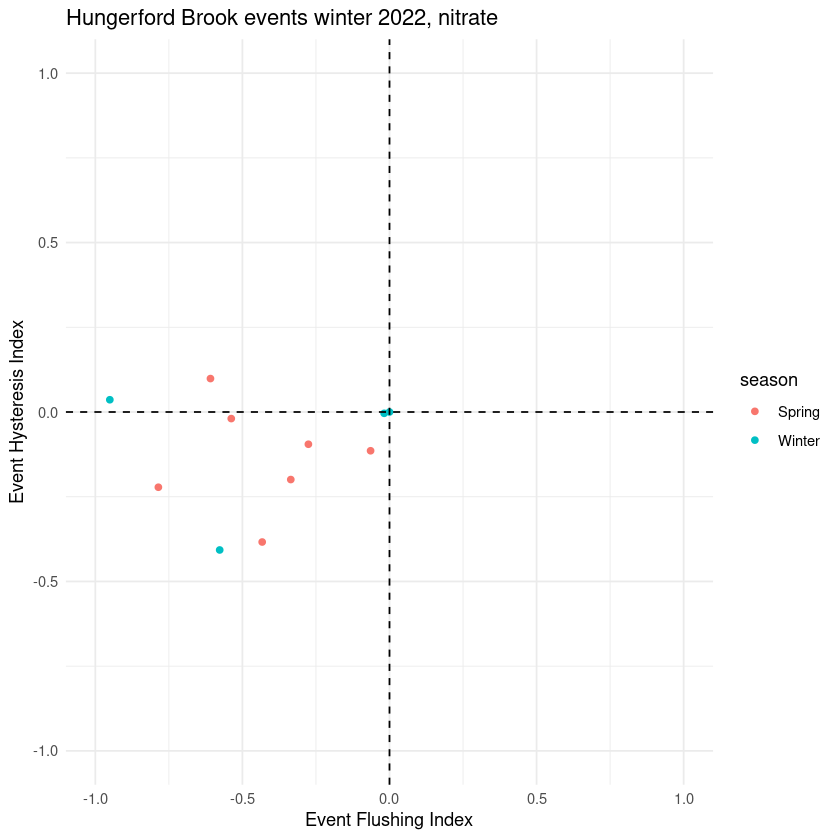

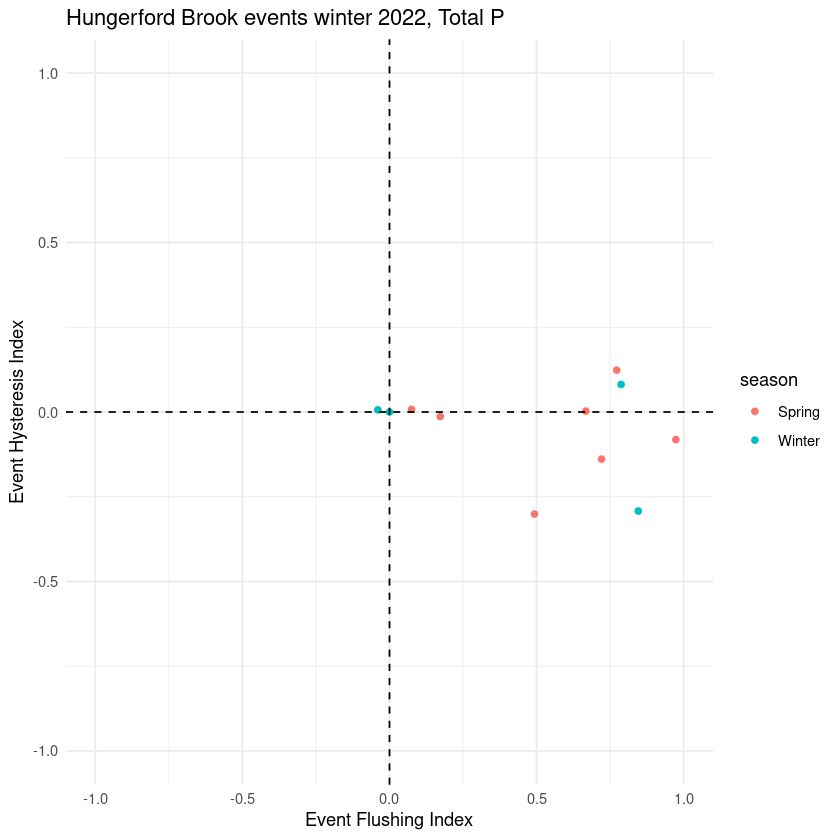

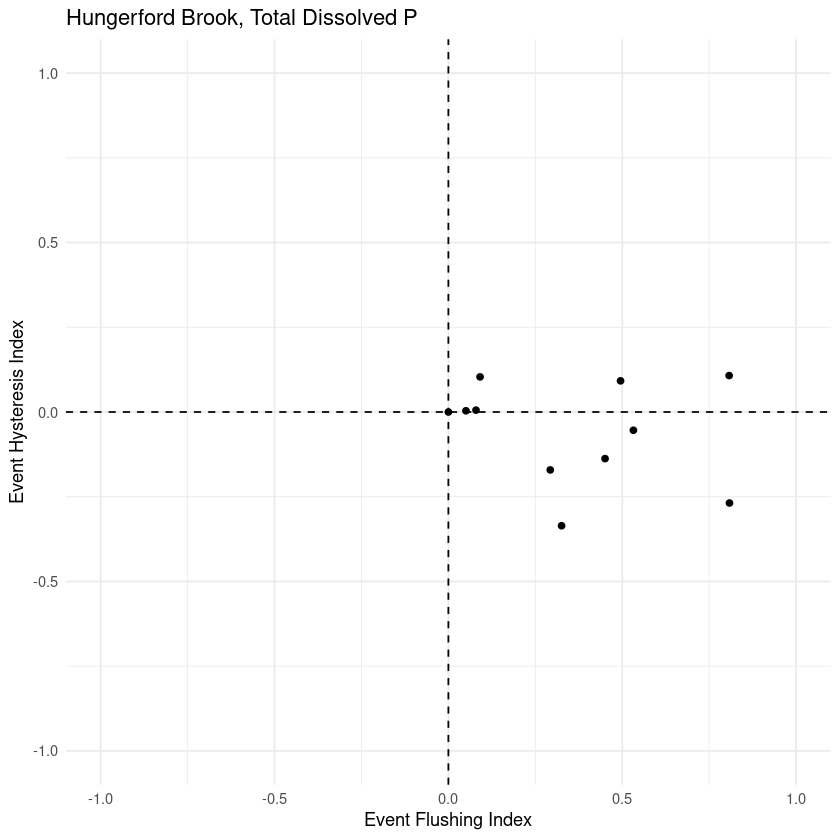

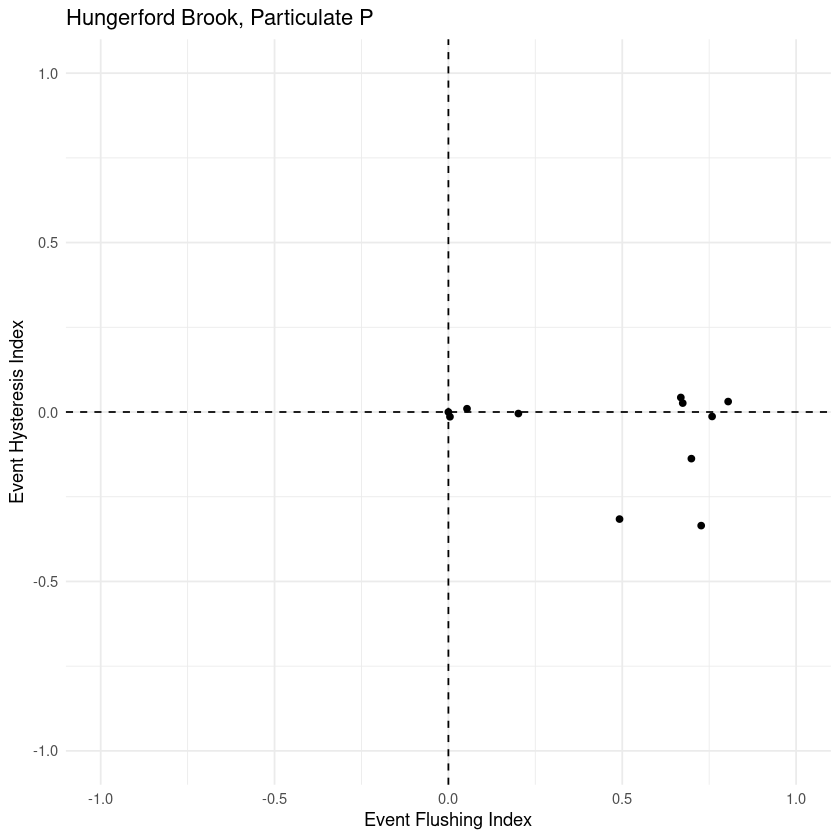

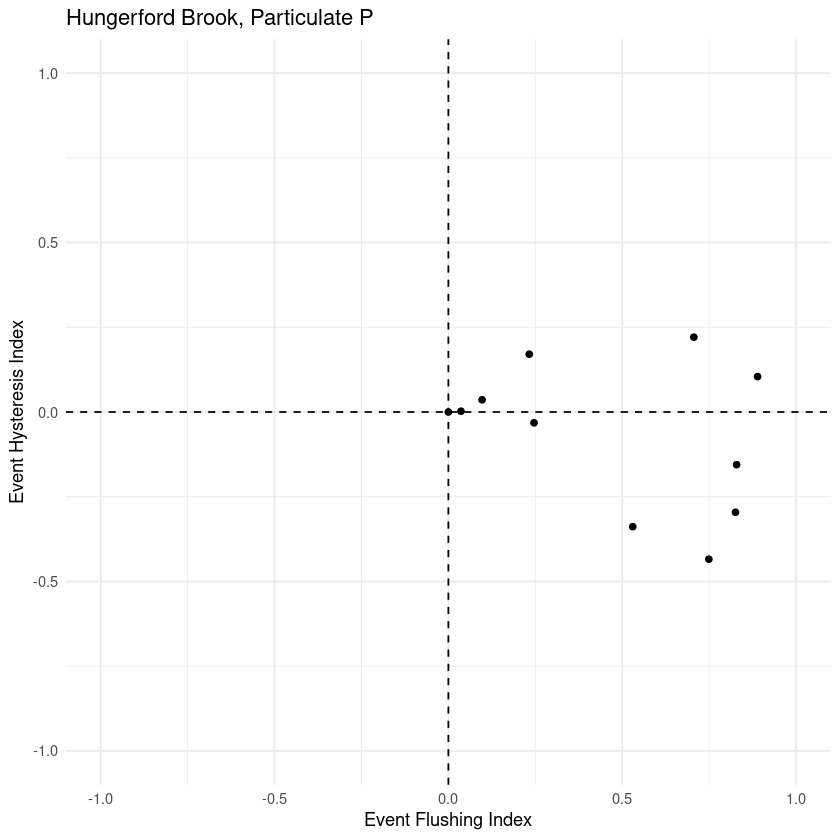

In [6]:
# Calculate the hysteresis and flushing indices based on Vaughan et al. 2017 (WRR)
# We are going to use the smoothed P time series for hysteresis (simple moving average over 9 rows; 9 * 15 min = 135 min or 2.25 hrs)

# To do:
# Need to triple check these calculations!
#setwd("/Users/smvogel/Desktop/2023 Data/Storm Delineation_cQ Code")

# Load packages
library("tidyverse")
library("lubridate")
library("data.table")
library("zoo")
library(dplyr)
library(ggplot2)

# Compile event delineations, chemistry, & discharge data into a single data frame
hb_events <- read.csv("hb_events_hyst_MED.csv")
hb_chem_q <- read.csv("hb_q_chem copy.csv")

hb_events$event_start <- as.POSIXct(hb_events$event_start, format="%m/%d/%y %H:%M")
hb_events$event_end <- as.POSIXct(hb_events$event_end, format="%m/%d/%y %H:%M")
hb_chem_q$datetime <- as.POSIXct(hb_chem_q$datetime, format="%Y-%m-%dT%H:%M:%SZ")
hb_chem_q$timestamp <- copy(hb_chem_q$datetime)

setDT(hb_events)
setDT(hb_chem_q)

# Define the function to determine the season based on the event_start date
get_season <- function(date) {
  month <- month(date)
  if (month %in% c(12, 1, 2)) {
    return("Winter")
  } else if (month %in% c(3, 4, 5)) {
    return("Spring")
  } else if (month %in% c(6, 7, 8)) {
    return("Summer")
  } else if (month %in% c(9, 10, 11)) {
    return("Fall")
  }
}


# Perform a non-equi join to match rows within the date range
#This data frame just has q/chem data that corresponds with an event
merged_data <- hb_chem_q[hb_events, on = .(datetime >= event_start, datetime <= event_end), nomatch = 0, allow.cartesian = TRUE]

merged_data <- merged_data %>%
  rename(event_end = datetime.1) %>%
  rename(event_start = datetime)

all_data <- merged_data %>%
  # Simplify analyte names from mg/L to just chem. abbrev.
  #rename(TP = TP_mgL) %>% 
  # Simplify q_cms to just q
  rename(q = q_cms_hb_filled) %>%
  # # Filter rows without chemistry
  filter(!is.na(NO3)) %>% 
  filter(!is.na(TDP)) %>% 
  filter(!is.na(TP)) %>% 
  filter(!is.na(SRP)) %>% 
  filter(!is.na(PP)) %>% 
  # Add a condition column, i.e., event vs. baseflow
  mutate(condition = ifelse(is.na(event_ID), "baseflow", "event")) %>% 
  # Add a year column
  mutate(year = year(timestamp))
# Rearrange columns
#select(timestamp, year, condition, event_start, event_end, q, NO3, TP)


# Prepare the data ----
# Look at event data only
eventdata <- all_data %>% 
  filter(condition == "event") %>% 
  # Keep only necessary columns
  #select(site, timestamp, event_start, event_end, q, NO3, TP, SRP) %>% 
  # Try removing rows with no Q
  filter(!is.na(q))

# Create Q sequence onto which we'll interpolate later
q_step <- hb_events %>% select(event_start, event_end)
# Check to see how many unique site + storms there are
# howmany <- q_step %>% group_by(site, event_start) %>% summarize(count = n())
# q_step <- setDT(q_step)[, list(q = seq(from = 0, to = 1, by = 0.01)), by = c("site", "event_start", "event_end")]
# Using mutate(q = q/100) below because creating a vector using by = 0.01 resulted in floating point precision problems later in the script
# https://stackoverflow.com/questions/55956654/when-i-use-dplyrfilter-and-a-sequence-command-it-randomly-skips-rows-it-should/55958991#55958991
q_step <- setDT(q_step)[, list(q = seq(from = 0, to = 100)), by = c("event_start", "event_end")] %>% 
  mutate(q = q/100)


# Slice the data on the rising limb of each storm
# If a solute concentration doesn't change during a storm, e.g., when NO3 is at MDL, the normalization will produce NaN (can't devide by 0)
hyst_rise <- eventdata %>% 
  # Normalize (between 0 and 1) Q and solutes
  group_by(event_start) %>% 
  # mutate(q_norm = (q - min(q)) / (max(q) - min(q))) %>% 
  mutate_at(vars(c(q, NO3, TP, SRP, TDP, PP)),
            .funs = list(~ (. - min(.)) / (max(.) - min(.)))) %>%
  # funs((. - min(.)) / (max(.) - min(.)))) %>%
  # Arrange data by site and timestamp for the slice below
  arrange(timestamp) %>% 
  # Slice data from start of storm to max q
  slice(1:which.max(q)) %>% 
  select(-timestamp) %>% 
  ungroup()

# Slice the data on the falling limb of each storm 
hyst_fall <- eventdata %>% 
  group_by(event_start) %>% 
  mutate_at(vars(c(q, NO3, TP, SRP, TDP, PP)),
            .funs = list(~ (. - min(.)) / (max(.) - min(.)))) %>%
  # funs((. - min(.)) / (max(.) - min(.)))) %>%
  arrange(timestamp) %>% 
  # Select rows from max Q to end of the storm
  slice(which.max(q):length(q)) %>% 
  # Slice again, this time from max Q to the first minimum Q for the storm
  slice(1:which.min(q)) %>%
  select(-timestamp) %>% 
  ungroup()


# 1. Join the q_step to hyst_rise & hyst_fall
# 2. Interpolate missing normalized solute values
# Convert q_step, hyst_rise & hyst_fall to DT's and set the keys to join on
setDT(q_step)
setkey(q_step, event_start, event_end, q)
setDT(hyst_rise)
setkey(hyst_rise, event_start, event_end, q)
setDT(hyst_fall)
setkey(hyst_fall, event_start, event_end, q)

### saved version 
hyst_rise <- 
  # Join with q_step & sort data
  merge(hyst_rise, q_step, all = TRUE)[order(event_start, q)] %>% 
  # Rename columns
  rename(NO3_rise = NO3, TP_rise = TP, SRP_rise = SRP, TDP_rise = TDP, PP_rise = PP) %>% 
  # Interpolate missing normalized solute values
  group_by(event_start) %>%                         ###    <------  CODE IS BREAKING HERE "Error in .f(.x[[i]], ...) : object 'NO3' not found"
  mutate_at(vars(c(NO3_rise, TP_rise, SRP_rise, TDP_rise, PP_rise)),
            # funs(na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
            .funs = list(~ na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
  # Only keep rows where q matches the q_step above
  filter(q %in% (seq(1,100)/100)) %>% 
  # Take the average of any duplicate values of Q for each site and storm
  gather(key = "var", value = "val", c(NO3_rise, TP_rise, SRP_rise, TDP_rise, PP_rise)) %>% 
  group_by(event_start, event_end, q, var) %>% 
  summarize(val = mean(val, na.rm = T)) %>% 
  spread(var, val) %>% 
  ungroup()

# # Examine individual storm
# test <- hyst_rise %>%
#   filter(site == "Wade" & event_start == ymd_hms("2015-10-14 08:30:00", tz = "Etc/GMT-4"))

hyst_fall <- 
  merge(hyst_fall, q_step, all = TRUE)[order(event_start, q)] %>% 
  rename(NO3_fall = NO3, TP_fall = TP, SRP_fall = SRP, TDP_fall = TDP, PP_fall = PP) %>% 
  group_by(event_start) %>% 
  mutate_at(vars(c(NO3_fall, TP_fall, SRP_fall, TDP_fall, PP_fall)),
            # funs(na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
            .funs = list(~ na.approx(., x = q, xout = q, na.rm = FALSE))) %>% 
  filter(q %in% (seq(1,100)/100)) %>% 
  # Take the average of any duplicate values of Q for each site and storm
  gather(key = "var", value = "val", c(NO3_fall, TP_fall, SRP_fall, TDP_fall, PP_fall)) %>% 
  group_by(event_start, event_end, q, var) %>% 
  summarize(val = mean(val, na.rm = T)) %>% 
  spread(var, val) %>% 
  ungroup()     

# Join hyst_rise & hyst_fall
hysteresis <- full_join(hyst_rise, hyst_fall, by = c("event_start", "event_end", "q")) %>% 

  # mutate() ifelse() solution
  mutate(NO3_fall = ifelse(q == 1, NO3_rise, NO3_fall),
         TP_fall = ifelse(q == 1, TP_rise, TP_fall),
         SRP_fall = ifelse(q == 1, SRP_rise, SRP_fall), 
         TDP_fall = ifelse(q == 1, TDP_rise, TDP_fall),
         PP_fall = ifelse(q == 1, PP_rise, PP_fall))


# # Examine individual storm
# test <- hysteresis %>%
#   filter(site == "Wade" & event_start >= ymd_hms("2015-10-14 08:30:00", tz = "Etc/GMT-4"))

# Calculate HI & FI ----
# Function to spread multiple value columns at once
# https://community.rstudio.com/t/spread-with-multiple-value-columns/5378
spread_n <- function(df, key, value) {
  # quote key
  keyq <- rlang::enquo(key)
  # break value vector into quotes
  valueq <- rlang::enquo(value)
  s <- rlang::quos(!!valueq)
  df %>% gather(variable, value, !!!s) %>%
    unite(temp, !!keyq, variable) %>%
    spread(temp, value)
}

# Calculate HI mean, sd, & CV
HI <- hysteresis %>% 
  # Subtract the normalized concentration on the falling limb from the rising limb for each normalized level of Q
  mutate(HI_NO3 = NO3_rise - NO3_fall,
         HI_TP = TP_rise - TP_fall,
         HI_TDP = TDP_rise - TDP_fall,
         HI_SRP = SRP_rise - SRP_fall,
         HI_PP = PP_rise - PP_fall) %>% 
  # Calculate the mean of HI for each storm and variable
  gather(key = "var", value = "HI", c(HI_NO3, HI_TP, HI_TDP, HI_SRP, HI_PP)) %>% 
  group_by(event_start, event_end, var) %>% 
  summarize(mean = mean(HI, na.rm = TRUE),
            sd = sd(HI, na.rm = TRUE),
            cv = sd/mean) %>% 
  spread_n(var, c(mean, sd, cv)) %>% 
  ungroup()

# Calculate FI
FI <- hysteresis %>% 
  # Shed *_fall columns
  select(-c(ends_with("fall"))) %>% 
  # 
  gather(key = "var", value = "conc", c(ends_with("rise"))) %>% 
  group_by(event_start, var) %>% 
  # Keep only rows with minimum and maximum Q values (i.e., ~0.01 and 1) which have a concentration value (mostly a concern for minimum value)
  filter(!is.na(conc)) %>%
  filter(q == min(q) | q == max(q)) %>% 
  # Subtract norm. conc. at min. Q from norm. conc. at max. Q
  arrange(q, .by_group = TRUE) %>% 
  mutate(FI = conc - lag(conc, default = first(conc))) %>% 
  # Only keep value at max. Q (this is the FI)
  filter(q == max(q)) %>% 
  # Rearrange the df
  select(-c(q, conc)) %>% 
  spread(var, FI) %>% 
  rename(FI_NO3 = NO3_rise, FI_TP = TP_rise, FI_TDP = TDP_rise, FI_PP = PP_rise, FI_SRP = SRP_rise) %>% 
  ungroup()

# Join HI & FI
hyst_indices <- full_join(FI, HI, by = c("event_start", "event_end"))

# Add a season column to the hyst_indices dataframe
hyst_indices <- hyst_indices %>%
  mutate(season = sapply(event_start, get_season))


hb_no3 <- ggplot(hyst_indices, aes(x = FI_NO3, y = HI_NO3_mean, color = season)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook events winter 2022, nitrate",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_no3)  

hb_tp <- ggplot(hyst_indices, aes(x = FI_TP, y = HI_TP_mean, color = season)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook events winter 2022, Total P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_tp)

hb_tdp <- ggplot(hyst_indices, aes(x = FI_TDP, y = HI_TDP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Total Dissolved P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_tdp)  

 hb_pp <- ggplot(hyst_indices, aes(x = FI_PP, y = HI_PP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Particulate P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_pp)

hb_srp <- ggplot(hyst_indices, aes(x = FI_SRP, y = HI_SRP_mean)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  labs(title = "Hungerford Brook, Particulate P",
       x = "Event Flushing Index",
       y = "Event Hysteresis Index") +
  xlim(-1, 1) +
  ylim (-1,1) +
  theme_minimal()
plot(hb_srp)

# Write hyst_indices
hyst_indices %>% 
  mutate(event_start = as.character(event_start),
         event_end = as.character(event_end)) %>% 
  write_csv("hungerford_hyst_indices.csv")
